## 13장. 텍스트마이닝_감성분석과 토픽분석
- pandas 버전이 1.1.4 이상인지 확인하고, 아니라면 upgrade 하기. (pyLDA 에러 때문)
- ★★ 11장 결정트리분석에서 Pandas를 하위버전으로 설치하였으므로,  최신버전으로 업그레이드 설치한다. 
- Anaconda Prompt 를 [관리자권한으로 실행] 한 후에, 명령어 입력:  pip  install  --upgrade  pandas 
- -> 업그레이드 설치를 적용하기 위해서, Jupyter Notobook을 종료했다가 다시 실행하기 !!

---
# 1부. 감성 분류 모델 구축

In [11]:
#import pandas as pd
#pd.show_versions()

import pandas as pd
print(pd.__version__)

# 한글 UnicoedEncodingError를 방지하기 위해 기본 인코딩을 "utf-8"로 설정
import os
os.environ["PYTHONIOENCODING"] = "utf-8"
import time

# 경고메시지 표시 안하게 설정하기
import warnings
warnings.filterwarnings(action='ignore')

2.0.1


In [24]:
!pip3 install --upgrade pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 1.7 MB/s eta 0:00:0000:0100:01
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 1.7 MB/s eta 0:00:0000:0100:01
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


---
### 1-1. 데이터 수집
- 깃허브에서 데이터 파일 다운로드 : https://github.com/e9t/nsmc
- id   /   document    /    label(긍정/부정)

---
### 1-2. 데이터 준비 및 탐색

In [2]:
# (1) 훈련용 데이터 파일 로드
nsmc_train_df = pd.read_csv('/Users/min0/Documents/Documents/school/4-1/빅데이터/자료/week12/DATA/ratings_train.txt', encoding='utf8', sep='\t', engine='python')
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# (2) 데이터의 정보 확인
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [4]:
# (3) 'document'칼럼이 Null인 샘플 제거
nsmc_train_df = nsmc_train_df[nsmc_train_df['document'].notnull()]
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [5]:
# (4) 타겟 컬럼 label 확인 (0: 부정,   1: 긍정)
nsmc_train_df['label'].value_counts()

0    75170
1    74825
Name: label, dtype: int64

In [6]:
# (5) 한글 이외의 문자는 공백으로 변환 (정규표현식 이용): 어떤 단어가 긍정이고 부정인지 단어 학습을 위함
import re

nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 1-3. 평가용 데이터 준비

In [8]:
# (1) 평가용 데이터 파일 로드
nsmc_test_df = pd.read_csv('/Users/min0/Documents/Documents/school/4-1/빅데이터/자료/week12/DATA/ratings_test.txt', encoding='utf8', sep='\t', engine='python')
nsmc_test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [9]:
#(2) 데이터의 정보 확인
nsmc_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [10]:
# (3) 'document'칼럼이 Null인 샘플 제거
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()]

In [11]:
# (4) 타겟 컬럼 label 확인 (0: 부정, 1: 긍정)
print(nsmc_test_df['label'].value_counts())

1    25171
0    24826
Name: label, dtype: int64


In [12]:
# (5) 한글 이외의 문자는 공백으로 변환 (정규표현식 이용)
nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', "", x))

### 1-3. 분석 모델 구축: 피처 벡터화 : TF-IDF

In [13]:
# (1) 형태소를 분석하여 토큰화 : 한글 형태소 엔진으로 Okt 이용
# get_ipython().system('pip install konlpy')

from konlpy.tag import Okt
okt = Okt()

def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

In [ ]:
# (2) TF-IDF 기반 피처 벡터 생성 : 실행시간 10분 이상 걸립니다 ☺

In [14]:
start=time.time()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])
end=time.time();print(end-start)

1188.369913816452


### 1-4 감성 분류 모델 구축 : 로지스틱 회귀를 이용한 이진 분류

In [15]:
# Sentiment Analysis using Logistic Regression
# (1) 로지스틱 회귀 기반 분석모델 생성

from sklearn.linear_model import LogisticRegression
SA_lr = LogisticRegression(random_state = 0)
# 라벨을 로지스틱 회귀 모델에 넣고 학습: 이 값이 긍정이고 이 값은 부정이군아..
SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])

LogisticRegression(random_state=0)

In [16]:
# (2) 로지스틱 회귀의 여러 파라미터 중  best 하이퍼 파라미터 찾기
from sklearn.model_selection import GridSearchCV
params = {'C': [1, 3, 3.5, 4, 4.5, 5]} 

# GridSearchCV: 한꺼번에 여러 개 실행해보고 어느 파라미터에 대한 정확도가 젤 높은지 최적 찾기
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)

In [17]:
# (3) 최적 분석 모델 훈련(11분 이상 소요..)
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'C': 3} 0.8553


In [18]:
# C가 3일 때 정확도가 가장 높다.

# 최적 파라미터의 best 모델 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_

### 1-5. 분석 모델 평가

In [19]:
# 1) 평가용 데이터를 이용하여 감성 분석 모델 정확도
# 평가용 데이터의 피처 벡터화 : 실행시간 6분 정도 걸립니다 ☺
start=time.time()
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])
test_predict = SA_lr_best.predict(nsmc_test_tfidf)
end=time.time(); print(end-start)

190.16839790344238


In [20]:
from sklearn.metrics import accuracy_score
print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))

감성 분석 정확도 :  0.857


### 1-6. 새로운 텍스트에 대한 감성 예측

In [100]:
st = input('감성 분석할 문장입력 >> ')

# 0) 입력 텍스트에 대한 전처리 수행
st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st); print(st)
st = [" ".join(st)]; print(st)
# 1) 입력 텍스트의 피처 벡터화
st_tfidf = tfidf.transform(st)
# 2) 최적 감성분석 모델에 적용하여 감성 분석 평가
st_predict = SA_lr_best.predict(st_tfidf)
# 3) 예측 값 출력하기
if(st_predict== 0):
    print(st , "->> 부정 감성")
else :
    print(st , "->> 긍정 감성")

감성 분석할 문장입력 >> 내가 뭘 본 거지, 좀비 공포 호러영화본듯
['내가', '뭘', '본', '거지', '좀비', '공포', '호러영화본듯']
['내가 뭘 본 거지 좀비 공포 호러영화본듯']
['내가 뭘 본 거지 좀비 공포 호러영화본듯'] ->> 부정 감성


---
# 2부. 감성 분석 수행 

---
### 2-1. 감성 분석할 데이터 수집
- 4장에서 학습한 네이버 API를 이용한 크롤링 프로그램을 이용하여, 네이버 뉴스를 크롤링하여 텍스트 데이터를 수집한다

---
### 2-2. 데이터 준비 및 탐색

In [29]:
# (1) 파일 불러오기
import json
file_name = '/Users/min0/Documents/Documents/school/4-1/빅데이터/자료/week12/DATA/코로나_naver_news'

with open(file_name+'.json', encoding='utf8') as j_f:
    data = json.load(j_f)
print(data)

[{'cnt': 1, 'description': '신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19) 변이 오미크론 대확산으로 군부대에서도 확진자가 폭증하고 있는 가운데 이로 인해 업무가 늘어난 비확진자들 사이에서 &quot;<b>코로나</b> 안 걸린 병사들만 호구&quot;라는 불만의 목소리가... ', 'link': 'https://www.sedaily.com/NewsView/263K1LCU7K', 'org_link': 'https://www.sedaily.com/NewsView/263K1LCU7K', 'pDate': '2022-03-25 20:34:00', 'title': "&quot;<b>코로나</b> 안 걸린 병사만 호구&quot; 軍 내부, '업무 가중' 불만 폭발"}, {'cnt': 2, 'description': '오미크론 변이 이후 급증하던 <b>코로나</b>19 확진자 수가 다소 주춤하는 모습이다. 25일 오후 6시까지 전국의 <b>코로나</b>19 신규 확진자 수는 25만명대를 기록했다. 방역당국과 서울시 등 각 지방자치단체에 따르면... ', 'link': 'http://www.inews24.com/view/1464137', 'org_link': 'http://www.inews24.com/view/1464137', 'pDate': '2022-03-25 20:34:00', 'title': "오미크론 정점 지났나?…25일 6시 확진자 26만여명 '소폭 감소'"}, {'cnt': 3, 'description': '또한 &quot;차량형 임시 선별진료소 운영으로 임시 선별진료소에 대한 접근 편의성이 개선될 것으로 예상된다. <b>코로나</b>19 유행 상황에 발맞춰 다각도로 활용할 예정&quot;이라고 밝혔다.', 'link': 'http://www.newsfreezone.co.kr/news/articleView.html?idxno=370508', 'org_link': 'http://www.newsfreezone.co.kr/news

In [31]:
# (2) 분석할 컬럼을 추출하여 데이터 프레임에 저장
data_title =[]
data_description = []

for item in data:
    data_title.append(item['title'])
    data_description.append(item['description'])

data_df = pd.DataFrame({'title':data_title, 'description':data_description})
data_df

,title,description
0,"&quot;<b>코로나</b> 안 걸린 병사만 호구&quot; 軍 내부, '업무 가...",신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19) 변이 오미크론 대확...
1,오미크론 정점 지났나?…25일 6시 확진자 26만여명 '소폭 감소',오미크론 변이 이후 급증하던 <b>코로나</b>19 확진자 수가 다소 주춤하는 모습...
2,"고양특례시, 차량형 임시 선별진료소 운영",또한 &quot;차량형 임시 선별진료소 운영으로 임시 선별진료소에 대한 접근 편의성...
3,"성남시, 2022년 제1회 추가경정예산 2359억원 확정","지원비, <b>코로나</b>19 예방접종시행비 등 569억원 규모의 국‧도비 보조사..."
4,"“새 정부 통상, 산업 수요를 반영한 최적의 조직 운용 필요”",무역협회 신승관 전무는 “<b>코로나</b>19와 미중 패권경쟁이 장기화되는 가운데...
...,...,...
995,봄에 가볼만한 수도권 관광명소...야생화 섬 안산 '풍도',올해는 특히 <b>코로나</b>19로 사람들의 발길이 뜸한 탓에 예년보다 더 많은 ...
996,"文회동 늦어지는 尹당선인, 내주 대구 달성 朴부터 찾나(종합)",김 대변인은 취재진의 '윤 당선인의 협치에 대한 노력'을 묻는 질문에 &quot;<...
997,"김진석 식약처 차장, 운반 급식업체 현장 점검","필요하다&quot;며, &quot;<b>코로나</b>19 방역수칙도 철저히 준수해 ..."
998,[주총] 김재옥 동원 대표 &quot;미래 먹거리 발굴과 품질 경영 확립할 것&quot;,"이어 &quot;<b>코로나</b> 이후 브랜드의 신뢰도가 높고, Value가 높은..."


In [32]:
# (3) 한글 이외 문자 제거
data_df['title'] = data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df['description'] = data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df.head() 

,title,description
0,코로나 안 걸린 병사만 호구 내부 업무 가중 불만 폭발,신종 코로나 바이러스 감염증 코로나 변이 오미크론 대확산으로 군부대에서도 확진자...
1,오미크론 정점 지났나 일 시 확진자 만여명 소폭 감소,오미크론 변이 이후 급증하던 코로나 확진자 수가 다소 주춤하는 모습이다 일 ...
2,고양특례시 차량형 임시 선별진료소 운영,또한 차량형 임시 선별진료소 운영으로 임시 선별진료소에 대한 접근 편의성이 개선될...
3,성남시 년 제 회 추가경정예산 억원 확정,지원비 코로나 예방접종시행비 등 억원 규모의 국 도비 보조사업도 편성했다 ...
4,새 정부 통상 산업 수요를 반영한 최적의 조직 운용 필요,무역협회 신승관 전무는 코로나 와 미중 패권경쟁이 장기화되는 가운데 우크라이나 사...


### 2-3. 감성 분석 수행

In [33]:
### 'title'에 대한 감성 분석

# 1) 분석할 데이터의 피처 벡터화 ---<< title >> 분석
data_title_tfidf = tfidf.transform(data_df['title'])
# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_title_predict = SA_lr_best.predict(data_title_tfidf)
# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['title_label'] = data_title_predict

In [34]:
### 'description' 에 대한 감성 분석

# 1) 분석할 데이터의 피처 벡터화 ---<< description >> 분석
data_description_tfidf = tfidf.transform(data_df['description'])
# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_description_predict = SA_lr_best.predict(data_description_tfidf)
# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['description_label'] = data_description_predict

In [35]:
data_df

,title,description,title_label,description_label
0,코로나 안 걸린 병사만 호구 내부 업무 가중 불만 폭발,신종 코로나 바이러스 감염증 코로나 변이 오미크론 대확산으로 군부대에서도 확진자...,0,0
1,오미크론 정점 지났나 일 시 확진자 만여명 소폭 감소,오미크론 변이 이후 급증하던 코로나 확진자 수가 다소 주춤하는 모습이다 일 ...,0,0
2,고양특례시 차량형 임시 선별진료소 운영,또한 차량형 임시 선별진료소 운영으로 임시 선별진료소에 대한 접근 편의성이 개선될...,0,0
3,성남시 년 제 회 추가경정예산 억원 확정,지원비 코로나 예방접종시행비 등 억원 규모의 국 도비 보조사업도 편성했다 ...,1,0
4,새 정부 통상 산업 수요를 반영한 최적의 조직 운용 필요,무역협회 신승관 전무는 코로나 와 미중 패권경쟁이 장기화되는 가운데 우크라이나 사...,1,0
...,...,...,...,...
995,봄에 가볼만한 수도권 관광명소 야생화 섬 안산 풍도,올해는 특히 코로나 로 사람들의 발길이 뜸한 탓에 예년보다 더 많은 야생화를 볼 ...,1,1
996,회동 늦어지는 당선인 내주 대구 달성 부터 찾나 종합,김 대변인은 취재진의 윤 당선인의 협치에 대한 노력 을 묻는 질문에 코로나 확...,0,1
997,김진석 식약처 차장 운반 급식업체 현장 점검,필요하다 며 코로나 방역수칙도 철저히 준수해 달라 고 말했다 한편 식약처는...,0,0
998,주총 김재옥 동원 대표 미래 먹거리 발굴과 품질 경영 확립할 것,이어 코로나 이후 브랜드의 신뢰도가 높고 가 높은 제품을 구매하는 경향이 심화됐...,1,1


In [ ]:
# 분석 결과가 추가된 데이터프레임을 CSV 파일로 저장
# data_df.to_csv('./DATA/'+file_name+'.csv', encoding='euc-kr') 

### 2-4. 감성 분석 결과 확인 및 시각화 - 0: 부정감성,   1: 긍정감성

In [36]:
# 감성 분석 결과 확인
data_df.head()
print(data_df['title_label'].value_counts())
print(data_df['description_label'].value_counts())

0    640
1    360
Name: title_label, dtype: int64
0    620
1    380
Name: description_label, dtype: int64


In [38]:
# 결과 저장 : 긍정과 부정을 분리하여 CSV 파일 저장
columns_name = ['title','title_label','description','description_label']
NEG_data_df = pd.DataFrame(columns=columns_name)
POS_data_df = pd.DataFrame(columns=columns_name)

In [40]:
for i, data in data_df.iterrows(): 
    title = data["title"] 
    description = data["description"] 
    t_label = data["title_label"] 
    d_label = data["description_label"] 
    
    if d_label == 0: # 부정 감성 샘플만 추출
        NEG_data_df = NEG_data_df.append(pd.DataFrame([[title, t_label, description, d_label]],columns=columns_name),ignore_index=True)
    else : # 긍정 감성 샘플만 추출
        POS_data_df = POS_data_df.append(pd.DataFrame([[title, t_label, description, d_label]],columns=columns_name),ignore_index=True)
  
# 파일에 저장.
# NEG_data_df.to_csv('./DATA/'+file_name+'_NES.csv', encoding='euc-kr') 
# POS_data_df.to_csv('./DATA/'+file_name+'_POS.csv', encoding='euc-kr') 

In [54]:
print(len(NEG_data_df))
print(len(POS_data_df))

620
380


In [41]:
# 감성 분석 결과 시각화 : 바 차트

# (1) 명사만 추출하여 정리하기
# 긍정 감성의 데이터에서 명사만 추출하여 정리 
POS_description = POS_data_df['description']

POS_description_noun_tk = []

for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출

print(POS_description_noun_tk)

[['태건', '조직', '위원장', '이', '대해', '개발자', '참가자', '코로나', '사태', '이전', '가장', '성공', '행사', '다만', '코로나', '종식', '만큼', '온라인', '행사', '역시', '진행', '예정', '오프라인'], ['코로나', '로', '모두', '시기', '구민', '이번', '이벤트', '위로', '며', '앞', '공동체', '화폐', '로', '거듭', '서로', '음', '관심', '사랑', '고', '강조'], ['코로나', '확산', '한시', '유예', '회', '용품', '사용', '규제', '다시', '시행', '다음', '달', '식품', '접객', '영도구', '관계자', '생활', '패턴', '변화', '및', '코로나', '등', '영향', '회', '용품', '용량', '급증', '생활', '폐기물'], ['회장', '코로나', '를', '경남', '최고', '문다운', '모습', '약속', '며', '경영', '목표', '보고', '신문', '신문', '거듭', '도록', '최선', '노력', '고', '말'], ['코로나', '자가', '검사', '키트', '자료', '뉴시스', '일', '코로나', '자가', '검사', '키트', '개', '구매', '제한', '수량', '제한', '살', '수', '자가', '검사', '키트', '제조업체', '포장', '생산', '허용', '식품의약품안전처'], ['날', '총회', '코로나', '상황', '감안', '서면', '개최', '등', '이번', '총회', '포함', '년', '연속', '서면', '총회', '개최', '진', '기록', '총회', '본회', '이사회', '상정', '회칙', '개정안', '대해', '천', '명의', '참석'], ['관계자', '코로나', '로', '상황', '임', '대선', '주조', '후원', '지역', '장애인', '복지', '권익', '향상', '도움', '고', '말', '조우현', '

In [42]:
POS_description_noun_join = []

for d in POS_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1인 토큰은 제외
    POS_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성
    
print(POS_description_noun_join)

['태건 조직 위원장 대해 개발자 참가자 코로나 사태 이전 가장 성공 행사 다만 코로나 종식 만큼 온라인 행사 역시 진행 예정 오프라인', '코로나 모두 시기 구민 이번 이벤트 위로 공동체 화폐 거듭 서로 관심 사랑 강조', '코로나 확산 한시 유예 용품 사용 규제 다시 시행 다음 식품 접객 영도구 관계자 생활 패턴 변화 코로나 영향 용품 용량 급증 생활 폐기물', '회장 코로나 경남 최고 문다운 모습 약속 경영 목표 보고 신문 신문 거듭 도록 최선 노력', '코로나 자가 검사 키트 자료 뉴시스 코로나 자가 검사 키트 구매 제한 수량 제한 자가 검사 키트 제조업체 포장 생산 허용 식품의약품안전처', '총회 코로나 상황 감안 서면 개최 이번 총회 포함 연속 서면 총회 개최 기록 총회 본회 이사회 상정 회칙 개정안 대해 명의 참석', '관계자 코로나 상황 대선 주조 후원 지역 장애인 복지 권익 향상 도움 조우현 대선 주조 대표 봄바람 꽃처럼 신랑', '인수위 금융위 코로나 피해 소상 공인 자영 업자 손실 보상금 정책 계해 금융 방안 마련 산업 시대 혁신 성장 민간 투자 확대 대한 주문', '동대문구 장안 벚꽃 봄꽃 추억 만들기 김진 기자 동대문구 코로나 올해 봄꽃 축제 취소 대신 다음 중랑천 벚꽃 포토 야간 조명 시설 설치', '거치 분할 상환 코로나 최초 확산 시점 정책금융 기관 코로나 확산 피해 상공 중소기업 다음 원금 상환 도래 대출', '기자 금융 위원회 업무 보고 우선 코로나 피해 소상 공인 금융 지원 방안 논의 인수위 측은 금융위 코로나 피해 상공 대한 손실 보상금 지원 정책 계해 금융 방안', '코로나 최근 상공 자영 업자 우리 국민 호소 여러 가지 민생 문제 때문 문제 야당 여당 협력 모습', '모두 코로나 부상 이유 선수 선발 과정 어려움 아시아 최고 대결 만큼 에이스 이란 한국 킬러 사르 선발', '심선엽 마케팅 포스트 코로나 시대 창원 파크 시민 스포츠 파크 건립 당시 목표 야구 모든 창원 시민 가장 사랑 공간', '재판 다음 공판 진행 증인 

In [43]:
# 부정 감성의 데이터에서 명사만 추출하여 정리 
NEG_description = NEG_data_df['description']
NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출
    
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1]  #길이가 1인 토큰은 제외
    NEG_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성
print(NEG_description_noun_join)

['신종 코로나 바이러스 감염증 코로나 오미크론 확산 군부 진자 폭증 가운데 이로 업무 비확 진자 사이 코로나 병사 호구 불만 목소리', '오미크론 이후 급증 코로나 진자 수가 다소 주춤 모습 오후 전국 코로나 신규 진자 명대 기록 방역 당국 서울시 지방자치단체', '또한 차량 임시 진료 운영 임시 진료 대한 접근 편의 개선 예상 코로나 유행 상황 활용 예정', '지원 코로나 예방접종 시행 억원 규모 도비 보조사 업도 편성 성남시 년도 집행 지역 경제 활성화 코로나 어려움 성남 시민 위해 노력', '무역 협회 승관 전무 코로나 패권 경쟁 장기 가운데 우크라이나 사태 통상 문제 국가 안보 문제 직결 면서 출범 정부 국제 정세 대처', '주석 코로나 국면 이상 외국 방문 중국 방역 외빈 방중 제한 상황 한중 정상회담 조기 개최 필요성 공감 당선인', '강릉 코로나 진자 추가 발생 강릉시 보건소 강릉 검사 양성 판정 하루 코로나 진자 가운데 의원 항원', '방송인 홍석천 신종 코로나 바이러스 감염증 코로나 사태 장기 대한 심경 홍석천 자신 인스타그램 매일 방송 사진 게재', '의원 주요 정책 성공 통합 공항 이전 의성군 농업 발전 농업인 권익 향상 소상 공인 자영 업자 코로나 피해 보상 지원 확대 중소 농가 특별 지원 보조 사업 확대 기반 첨단 농업 청년 농업인', '코로나 대체 간병인 사실 병원 신세 춘자 간병인 지금 작년 누구 지금 실제 코로나', '코로나 진자 급증 정부 치료 제의 활용 확대 신규 진자 이틀 기자 정부 다음 코로나 치료 명분 도입 코로나', '경기도 성남시 코로나 확산 사망자 증가 내일 부터 장례 문화 사업 운영 확대 성남시 화장 가동 회로 가동 마감 시간 시간 연장 하루 화장', '동대문구 코로나 장기 화로 혈액 수급 위기 극복 구청 아트 갤러리 명의 직원 단체 헌혈 실시 사진 동대문구 제공 동대문구 코로나 장기 화로 혈액 수급 위기', '통화 주석 코로나 국면 이상 외국 방문 중국 방역 외빈 방중 제한 상황 한중 정상회담 조기 개최 공감',

In [44]:
# (2) dtm 구성 : 단어 벡터 값을 내림차순으로 정렬
# 긍정 감성 데이터에 대한 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬
POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

POS_vocab = dict() 
for idx, word in enumerate(POS_tfidf.get_feature_names()):
    POS_vocab[word] = POS_dtm.getcol(idx).sum()
    
POS_words = sorted(POS_vocab.items(), key=lambda x: x[1], reverse=True)
POS_words 

[('코로나', 27.092876905187044),
 ('상황', 11.13714880384876),
 ('지역', 8.036718030070515),
 ('통해', 7.969376581838594),
 ('확산', 7.7340696401377755),
 ('장기', 7.361084720899523),
 ('위해', 6.814062233856499),
 ('진자', 6.582685858691688),
 ('올해', 6.524733048676965),
 ('이번', 6.433826975510957),
 ('성장', 6.3950088396858185),
 ('대표', 6.245512565275363),
 ('화로', 6.1158115431212),
 ('시장', 6.0967350297536305),
 ('이후', 6.04615833330783),
 ('사회', 5.992983011305869),
 ('교육', 5.909590199166915),
 ('바이러스', 5.628871631903343),
 ('확진', 5.493523943678899),
 ('기업', 5.288959914668242),
 ('매출', 5.213227203855836),
 ('최근', 5.192579617980527),
 ('비대', 5.1427848092052155),
 ('팬데믹', 5.132850974236548),
 ('시기', 4.954409362291459),
 ('방역', 4.819031072396544),
 ('운영', 4.815307839707991),
 ('전국', 4.744948918146334),
 ('어려움', 4.738923625699412),
 ('신종', 4.564799524107453),
 ('경제', 4.453486299878618),
 ('백신', 4.36291606499841),
 ('지원', 4.34232578009952),
 ('진행', 4.327349537370901),
 ('감염증', 4.2560911286775145),
 ('위기', 4.241

In [45]:
# 부정 감성 데이터의 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

NEG_vocab = dict() 

for idx, word in enumerate(NEG_tfidf.get_feature_names()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
    
NEG_words = sorted(NEG_vocab.items(), key=lambda x: x[1], reverse=True)
NEG_words

[('코로나', 47.032771754121384),
 ('진자', 24.082531222215614),
 ('확진', 18.994131482991794),
 ('오후', 13.86225470471571),
 ('검사', 13.6763387014377),
 ('확산', 12.206009199572836),
 ('바이러스', 12.102717664336124),
 ('위해', 11.245859184477842),
 ('전국', 11.038537203738176),
 ('자가', 10.975818982233452),
 ('감염증', 10.822952605387503),
 ('신종', 10.462644826109699),
 ('신규', 10.312926218967547),
 ('방역', 10.296799213928836),
 ('지원', 10.215366514846473),
 ('지역', 10.001281979863677),
 ('발생', 9.983950353085431),
 ('판정', 9.846598699843565),
 ('키트', 9.39131987286451),
 ('상황', 9.36620926451334),
 ('치료', 9.029331625086423),
 ('감염', 8.77919709885792),
 ('가운데', 8.427372966054346),
 ('장기', 8.335842789110316),
 ('온스', 7.947745363692064),
 ('매출', 7.6633708506561895),
 ('오미크론', 7.618166557953913),
 ('정부', 7.539940702206559),
 ('제한', 7.475868567228332),
 ('기준', 7.317088318207047),
 ('지난', 7.247129240773235),
 ('판매', 7.215417459962846),
 ('해제', 7.151249272052257),
 ('시민', 6.921968829771302),
 ('이후', 6.827863478126855),
 (

In [48]:
# (3) 단어사전의 상위 단어로 바 차트 그리기

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
#font_location = 'C:/Windows/Fonts/malgun.ttf'
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)
plt.rcParams['font.family'] = 'AppleGothic'

max = 15  #바 차트에 나타낼 단어의 수 

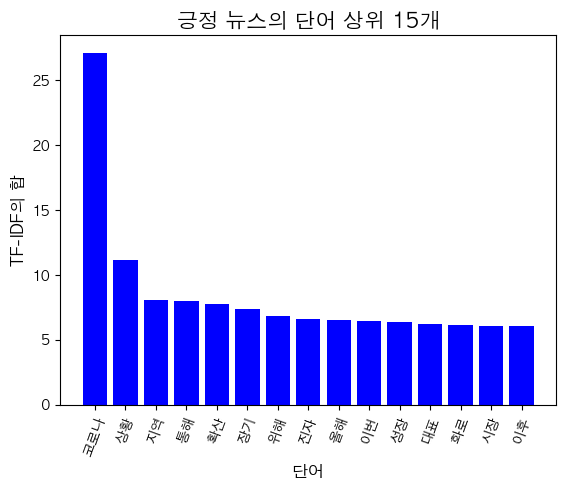

In [49]:
plt.bar(range(max), [i[1] for i in POS_words[:max]], color="blue")
plt.title("긍정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)
plt.show()

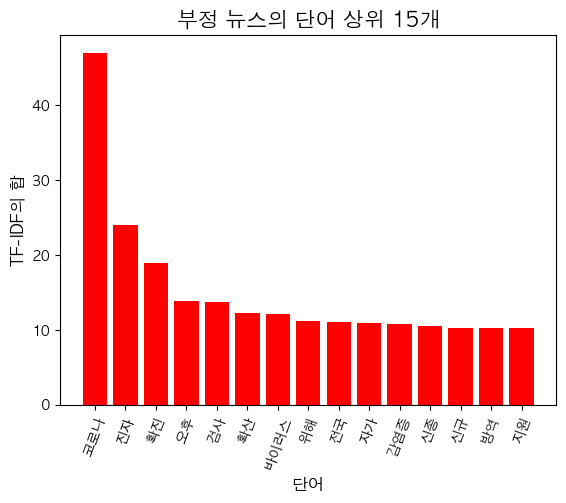

In [55]:
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color="red")
plt.title("부정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation=70)
plt.show()

---
# 3부. 토픽모델링 : LDA 기반 토픽 모델링
- 자주 하진 않음

### 3-1. 데이터 준비 

In [56]:
# 'description' 컬럼 추출
description = data_df['description']

In [57]:
# 형태소 토큰화 : 명사만 추출
description_noun_tk = []
for d in description:
    description_noun_tk.append(okt.nouns(d))

In [58]:
description_noun_tk2 = []

for d in description_noun_tk:
    item = [i for i in d if len(i) > 1]  #토큰의 길이가 1보다 큰 것만 추출
    description_noun_tk2.append(item)

print(description_noun_tk2)

[['신종', '코로나', '바이러스', '감염증', '코로나', '오미크론', '확산', '군부', '진자', '폭증', '가운데', '이로', '업무', '비확', '진자', '사이', '코로나', '병사', '호구', '불만', '목소리'], ['오미크론', '이후', '급증', '코로나', '진자', '수가', '다소', '주춤', '모습', '오후', '전국', '코로나', '신규', '진자', '명대', '기록', '방역', '당국', '서울시', '지방자치단체'], ['또한', '차량', '임시', '진료', '운영', '임시', '진료', '대한', '접근', '편의', '개선', '예상', '코로나', '유행', '상황', '활용', '예정'], ['지원', '코로나', '예방접종', '시행', '억원', '규모', '도비', '보조사', '업도', '편성', '성남시', '년도', '집행', '지역', '경제', '활성화', '코로나', '어려움', '성남', '시민', '위해', '노력'], ['무역', '협회', '승관', '전무', '코로나', '패권', '경쟁', '장기', '가운데', '우크라이나', '사태', '통상', '문제', '국가', '안보', '문제', '직결', '면서', '출범', '정부', '국제', '정세', '대처'], ['주석', '코로나', '국면', '이상', '외국', '방문', '중국', '방역', '외빈', '방중', '제한', '상황', '한중', '정상회담', '조기', '개최', '필요성', '공감', '당선인'], ['강릉', '코로나', '진자', '추가', '발생', '강릉시', '보건소', '강릉', '검사', '양성', '판정', '하루', '코로나', '진자', '가운데', '의원', '항원'], ['방송인', '홍석천', '신종', '코로나', '바이러스', '감염증', '코로나', '사태', '장기', '대한', '심경', '홍석천', '자신', '인스타그램', '매일', '방송', 

### 3-2. LDA 토픽 모델 구축

In [59]:
# LDA 모델의 입력 벡터 생성 

# 최초 한번만 설치
# get_ipython().system('pip install gensim   ')

import gensim
import gensim.corpora as corpora

In [60]:
# (1) 단어 사전 생성
dictionary = corpora.Dictionary(description_noun_tk2)
print(dictionary[1])

감염증


In [61]:
# (2) 단어와 출현빈도(count)의 코퍼스 생성
corpus = [dictionary.doc2bow(word) for word in description_noun_tk2]
print(corpus) #작업 확인용 출력

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 3), (15, 1), (16, 1), (17, 1)], [(11, 1), (13, 2), (14, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)], [(14, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1)], [(14, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)], [(0, 1), (14, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1)], [(14, 1), (24, 1), (36, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1),

In [62]:
# LDA 모델 생성 및 훈련 
k = 4  #토픽의 개수 설정
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus, iterations = 12, num_topics = k, id2word = dictionary, passes = 1, workers = 10)

### 3-3. LDA 토픽 분석 결과 시각화

In [63]:
# 토픽 분석 결과 확인
print(lda_model.print_topics(num_topics = k, num_words = 15))

[(0, '0.061*"코로나" + 0.009*"진자" + 0.008*"확진" + 0.007*"상황" + 0.006*"검사" + 0.005*"지역" + 0.005*"지원" + 0.005*"바이러스" + 0.004*"확산" + 0.004*"장기" + 0.004*"위해" + 0.004*"오후" + 0.004*"방역" + 0.004*"자가" + 0.004*"신종"'), (1, '0.052*"코로나" + 0.008*"진자" + 0.007*"확진" + 0.006*"위해" + 0.005*"확산" + 0.005*"방역" + 0.005*"검사" + 0.005*"전국" + 0.004*"지역" + 0.004*"오후" + 0.004*"자가" + 0.004*"발생" + 0.004*"지원" + 0.003*"이후" + 0.003*"장기"'), (2, '0.071*"코로나" + 0.007*"확산" + 0.007*"상황" + 0.006*"확진" + 0.006*"진자" + 0.005*"위해" + 0.005*"지역" + 0.004*"검사" + 0.004*"지원" + 0.004*"장기" + 0.004*"감염" + 0.004*"바이러스" + 0.004*"최근" + 0.003*"자가" + 0.003*"신종"'), (3, '0.058*"코로나" + 0.010*"진자" + 0.006*"바이러스" + 0.006*"상황" + 0.005*"위해" + 0.005*"확산" + 0.005*"확진" + 0.005*"감염증" + 0.004*"지역" + 0.004*"장기" + 0.004*"매출" + 0.004*"이번" + 0.004*"신종" + 0.003*"방역" + 0.003*"지원"')]


In [65]:
# 최초 한번만 설치
get_ipython().system('pip install pyLDAvis')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [ ]:
!pip install --upgrade pandas

In [96]:
# 토픽 분석 결과 시각화 : pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

In [97]:
pyLDAvis.enable_notebook()

In [99]:
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
lda_vis

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
pyLDAvis.display(lda_vis)
#pyLDAvis.save_html(lda_vis, './DATA/'+file_name+"_vis.html")
# 결과 ./DATA/코로나_naver_news_vis.html